### Import Libraries



In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import pickle
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import cv2
import sys

Using TensorFlow backend.


### Connect to Drive



In [2]:
# Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Read DataSet

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

### Classes

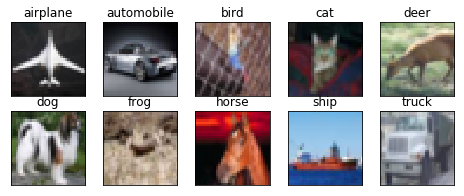

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Functions for Post Training Analysis 

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### Preparing Data

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Original Code

#### Model Architecture

In [8]:
# Define the model
model = Sequential()

# Convolution Block
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(32, 32, 3))) # Dim 32 RF 3
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Convolution Block
model.add(Convolution2D(64, 3, 3)) # Dim 30 RF 5
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Convolution Block
model.add(Convolution2D(128, 3, 3)) # Dim 28 RF 7
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Transition Block
model.add(Convolution2D(32, 1, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # Dim 14 RF 14

# Convolution Block
model.add(Convolution2D(64, 3, 3, border_mode='same')) # Dim 14 RF 12
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Convolution Block
model.add(Convolution2D(128, 3, 3)) # Dim 12 RF 14
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Convolution Block
model.add(Convolution2D(256, 3, 3)) # Dim 10 RF 16
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Partial Transition Block
model.add(Convolution2D(32, 1, 1, activation='relu'))


# Convolution Block
model.add(Convolution2D(64, 3, 3, border_mode='same')) # Dim 10 RF 18
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Convolution Block
model.add(Convolution2D(128, 3)) # Dim 8 RF 20
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Convolution Block
model.add(Convolution2D(256, 3)) # Dim 6 RF 22
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Output Block
model.add(Convolution2D(10, 1, activation='relu')) # Dim 6 RF 22
model.add(Convolution2D(10, 6)) # Dim 1 RF 28
model.add(Flatten())
model.add(Activation('softmax'))

W0629 20:47:02.441069 139931830990720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.
W0629 20:47:02.481420 139931830990720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0629 20:47:02.487544 139931830990720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0629 20:47:02.525049 139931830990720 deprecation_wrapper

#### Model summary

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 64)        0         
__________

#### Model Compile and Training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=195, epochs=100)`


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
195/195 [==============================] - 53s 270ms/step - loss: 0.5038 - acc: 0.8285 - val_loss: 0.7882 - val_acc: 0.7573

Epoch 00001: val_acc improved from -inf to 0.75730, saving model to Assignment6a//maxAccuracy.hdf5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
195/195 [==============================] - 48s 245ms/step - loss: 0.3933 - acc: 0.8610 - val_loss: 0.6921 - val_acc: 0.7825

Epoch 00002: val_acc improved from 0.75730 to 0.78250, saving model to Assignment6a//maxAccuracy.hdf5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
195/195 [==============================] - 47s 242ms/step - loss: 0.3414 - acc: 0.8791 - val_loss: 0.7108 - val_acc: 0.7879

Epoch 00003: val_acc improved from 0.78250 to 0.78790, saving model to Assignment6a//maxAccuracy.hdf5
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.00153

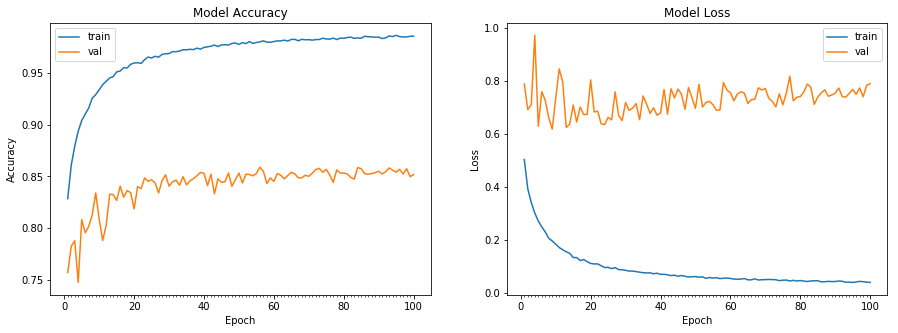

Accuracy on test data is: 85.17


In [60]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Image Normalization
datagen = ImageDataGenerator(zoom_range=0.0,featurewise_center=True, featurewise_std_normalization=True,
                             horizontal_flip=False) 

# LR Scheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

# Compile Model
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.003),
              metrics=['accuracy'])

# Checkpoint to save best model
!mkdir "Assignment6a"
filepath="Assignment6a//maxAccuracy.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, LearningRateScheduler(scheduler, verbose=1)]


start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=callbacks_list)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# # compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

#### Save Model

In [0]:
# !mkdir './drive/My Drive/EVA/'
model.save('./drive/My Drive/EVA/6a_CIFAR10-56-0.86.hdf5.h5')

### Modified Code with Cutout

#### Import Cutout

In [10]:
!wget "https://raw.githubusercontent.com/yu4u/cutout-random-erasing/master/random_eraser.py"
from random_eraser import get_random_eraser

--2019-06-29 20:47:08--  https://raw.githubusercontent.com/yu4u/cutout-random-erasing/master/random_eraser.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 888 [text/plain]
Saving to: ‘random_eraser.py’

random_eraser.py    100%[===================>]     888  --.-KB/s    in 0s      

2019-06-29 20:47:08 (166 MB/s) - ‘random_eraser.py’ saved [888/888]



#### Model Compile and Training

W0629 20:47:09.741569 139931830990720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=195, epochs=100)`
W0629 20:47:11.944663 13993183099072

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
195/195 [==============================] - 30s 153ms/step - loss: 1.8279 - acc: 0.3178 - val_loss: 2.1686 - val_acc: 0.3593

Epoch 00001: val_acc improved from -inf to 0.35930, saving model to Assignment9//maxAccuracy.hdf5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
195/195 [==============================] - 25s 126ms/step - loss: 1.4409 - acc: 0.4655 - val_loss: 3.3643 - val_acc: 0.2434

Epoch 00002: val_acc did not improve from 0.35930
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
195/195 [==============================] - 24s 123ms/step - loss: 1.2244 - acc: 0.5558 - val_loss: 1.5032 - val_acc: 0.4912

Epoch 00003: val_acc improved from 0.35930 to 0.49120, saving model to Assignment9//maxAccuracy.hdf5
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
195/195 [==============================] - 24s 

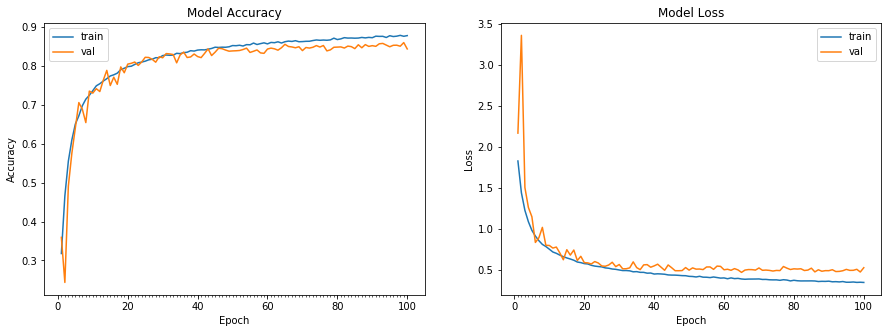

Accuracy on test data is: 84.38


In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Image Normalization
datagen = ImageDataGenerator(zoom_range=0.0,featurewise_center=True, featurewise_std_normalization=True,
                             horizontal_flip=False,preprocessing_function=get_random_eraser(s_l=0.25, s_h=0.25,v_l=0, v_h=1)) 

# LR Scheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

# Compile Model
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.003),
              metrics=['accuracy'])

# Checkpoint to save best model
!mkdir "Assignment9"
filepath="Assignment9//maxAccuracy.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, LearningRateScheduler(scheduler, verbose=1)]


start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=callbacks_list)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# # compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

#### Save Model

In [0]:
model.load_weights('./Assignment9//maxAccuracy.hdf5')
model.save('./drive/My Drive/EVA/6a_cutout_CIFAR10-99-0.86.hdf5.h5')

### GradCAM

In [0]:
def GradCam(testImage):
  img = testImage
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("activation_8")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(grads.shape[-1]):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  img = testImage
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  return superimposed_img

#### Image Index

In [0]:
imageIndex=[11, 14, 16, 20, 25, 39, 47, 54, 62, 63, 69, 89]

#### Load Model Weights (without Cutout)

In [0]:
model.load_weights('./drive/My Drive/EVA/6a_CIFAR10-56-0.86.hdf5.h5')

#### Gallary (without Cutout)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


(-0.5, 31.5, 31.5, -0.5)

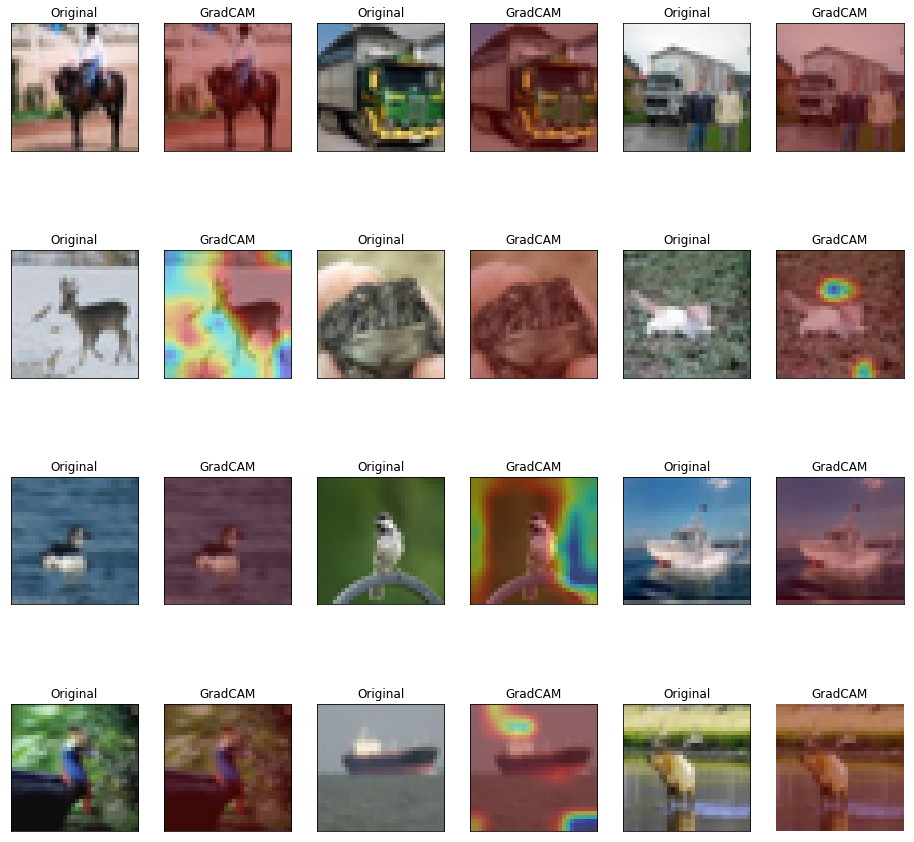

In [45]:
img = train_features[12]

fig = plt.figure(figsize=(16,16))

for i in range(12):
  
  img = train_features[imageIndex[i]]
  ax = fig.add_subplot(4, 6, 2*i+1, xticks=[], yticks=[])
  ax.set_title("Original")
  plt.imshow(img)
  ax = fig.add_subplot(4, 6, 2*i+2, xticks=[], yticks=[])
  ax.set_title("GradCAM")
  superimposed=GradCam(img)
  plt.imshow(superimposed)
plt.axis('off')

#### Load Model Weights (with Cutout)

In [0]:
model.load_weights('./drive/My Drive/EVA/6a_cutout_CIFAR10-99-0.86.hdf5.h5')

#### Gallary (with Cutout)

(-0.5, 31.5, 31.5, -0.5)

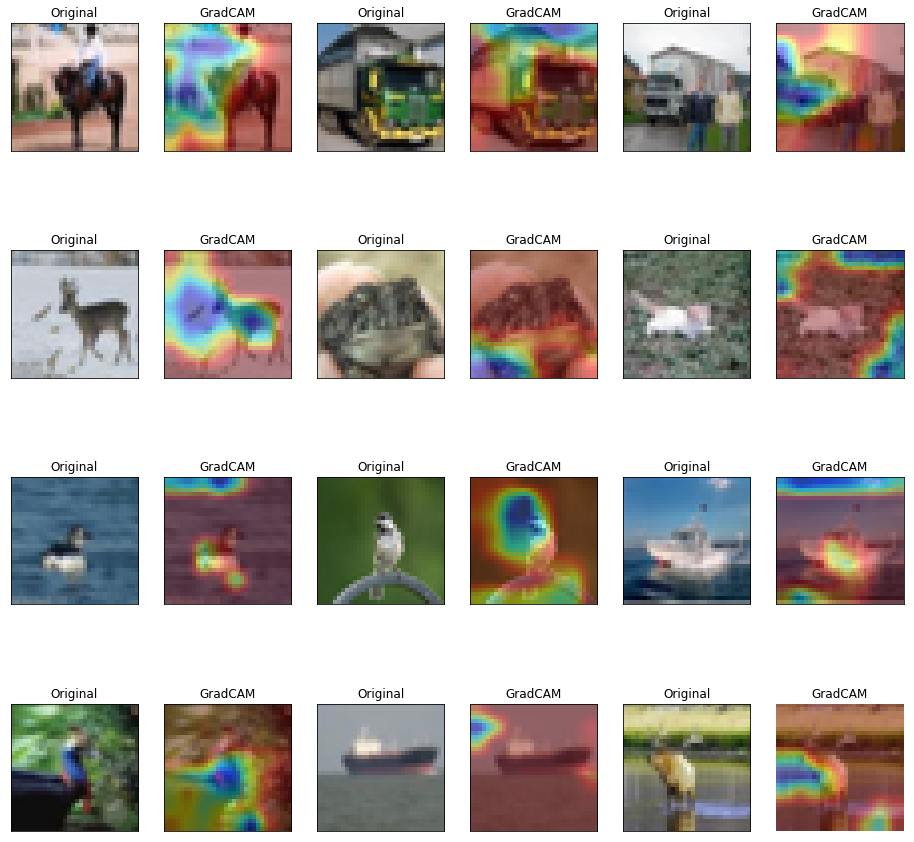

In [47]:
fig = plt.figure(figsize=(16,16))

for i in range(12):
  
  img = train_features[imageIndex[i]]
  ax = fig.add_subplot(4, 6, 2*i+1, xticks=[], yticks=[])
  ax.set_title("Original")
  plt.imshow(img)
  ax = fig.add_subplot(4, 6, 2*i+2, xticks=[], yticks=[])
  ax.set_title("GradCAM")
  superimposed=GradCam(img)
  plt.imshow(superimposed)
plt.axis('off')